In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import scipy.interpolate
import scipy.stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import os
import warnings

# Suppress warnings for a cleaner notebook
warnings.filterwarnings('ignore')

print("Libraries imported successfully.")

Libraries imported successfully.


In [2]:
# --- Signal Processing Constants ---
GEAR_RATIO = 5.095238095
SAMPLE_RATE_HZ = 93750.0
NYQUIST_HZ = SAMPLE_RATE_HZ / 2.0

# Bearing fault orders (cycles / revolution)
# [cage, ball, inner race, outer race]
FAULT_ORDERS_BPF = [0.43, 7.05, 10.78, 8.22]
FAULT_NAMES = ['Cage', 'Ball', 'InnerRace', 'OuterRace']

# --- Improved Design Constants ---

# 1. Multi-Band Analysis (instead of one fixed band)
# We will analyze these four bands to find the most sensitive one
BANDS_HZ = [
    (10000.0, 20000.0),
    (20000.0, 30000.0),
    (30000.0, 40000.0),
    (40000.0, 46000.0)  # Up to just below Nyquist
]

# 2. Rich Feature Extraction
HARMONICS_TO_EXTRACT = [1, 2, 3] # Extract 1x, 2x, and 3x harmonics
SEARCH_WIDTH_ORDER = 0.1 # Width to search around a peak

In [3]:
# --- File List ---
# Generate all 53 filenames
FILE_LIST = [f"file_{i:02d}.csv" for i in range(1, 54)]
print(f"File list generated, from {FILE_LIST[0]} to {FILE_LIST[-1]}")

File list generated, from file_01.csv to file_53.csv


In [4]:
def get_crest_factor(x):
    """Calculates the Crest Factor of a signal."""
    return np.max(np.abs(x)) / np.sqrt(np.mean(np.square(x)))

In [5]:
def extract_peak_amplitude(orders, spectrum_amplitude, target_order, search_width):
    """
    Finds the peak amplitude in the spectrum within a small window
    around the target_order.
    """
    order_min = target_order - search_width / 2.0
    order_max = target_order + search_width / 2.0

    band_indices = np.where((orders >= order_min) & (orders <= order_max))[0]

    if len(band_indices) > 0:
        return np.max(spectrum_amplitude[band_indices])
    else:
        return 0.0

In [6]:
def process_file_for_features_v3(filename):
    """
    Loads a single file and performs a FOCUSED feature extraction.
    1. Finds the single best frequency band (max kurtosis).
    2. Extracts a small, potent feature vector from *that band only*.
    """
    # --- 1. Load Data ---
    df = pd.read_csv(filename)
    v_signal = df['v'].values
    zct_times = df['zct'].dropna().values

    if len(zct_times) < 2:
        raise ValueError("Insufficient tach data")

    # --- 2. Angular Resampling (as before) ---
    t_v_axis = np.arange(len(v_signal)) / SAMPLE_RATE_HZ
    phi_at_zct = np.arange(len(zct_times)) * 2 * np.pi
    phase_interpolator = scipy.interpolate.interp1d(
        zct_times, phi_at_zct, kind='linear', fill_value="extrapolate"
    )
    phi_v_unwrapped = phase_interpolator(t_v_axis)
    phi_regular = np.linspace(
        phi_v_unwrapped.min(), phi_v_unwrapped.max(), len(phi_v_unwrapped)
    )
    v_resampled = np.interp(phi_regular, phi_v_unwrapped, v_signal)

    total_revolutions = (phi_regular[-1] - phi_regular[0]) / (2 * np.pi)
    num_samples = len(phi_regular)
    samples_per_rev_avg = num_samples / total_revolutions
    nyquist_order = samples_per_rev_avg / 2.0

    tach_periods = np.diff(zct_times)
    f_tach_inst = 1.0 / tach_periods
    mean_speed_hz = np.mean(f_tach_inst * GEAR_RATIO)

    # --- 3. Find the "Best Band" (Poor Man's Kurtogram) ---
    best_band_data = {
        'kurtosis': -1,
        'band_name': '',
        'envelope': None,
        'band_orders': (0,0)
    }

    for (band_low_hz, band_high_hz) in BANDS_HZ:

        band_low_order = band_low_hz / mean_speed_hz
        band_high_order = band_high_hz / mean_speed_hz
        if band_high_order >= nyquist_order:
            band_high_order = nyquist_order * 0.99

        try:
            b, a = scipy.signal.butter(
                4, [band_low_order, band_high_order],
                btype='band', fs=samples_per_rev_avg
            )
            v_filtered = scipy.signal.lfilter(b, a, v_resampled)
            envelope = np.abs(scipy.signal.hilbert(v_filtered))
            kurt = scipy.stats.kurtosis(envelope, fisher=False)

            # If this band's kurtosis is higher, it's our new "best"
            if kurt > best_band_data['kurtosis']:
                best_band_data = {
                    'kurtosis': kurt,
                    'band_name': f"band_{int(band_low_hz/1000)}k",
                    'envelope': envelope,
                    'band_orders': (band_low_order, band_high_order)
                }
        except ValueError:
            continue # Skip this band if filter fails

    # --- 4. Extract Features *from the Best Band Only* ---

    file_features = {}

    # Get the envelope, kurtosis, and rms from the best band
    best_envelope = best_band_data['envelope']
    file_features['best_kurtosis'] = best_band_data['kurtosis']

    # Calculate RMS of the *best band's envelope*
    file_features['best_env_rms'] = np.sqrt(np.mean(np.square(best_envelope)))

    # --- 5. Get Total Fault Energy *from the Best Band Only* ---
    envelope_demeaned = best_envelope - np.mean(best_envelope)

    # Get Amplitude Spectrum
    spectrum_amplitude = np.abs(np.fft.fft(envelope_demeaned))
    order_axis = np.fft.fftfreq(num_samples) * samples_per_rev_avg

    positive_mask = order_axis >= 0
    orders = order_axis[positive_mask]
    spectrum_amplitude = spectrum_amplitude[positive_mask]

    # Extract peaks for all faults and harmonics
    total_fault_energy = 0
    for fault_name, fault_order in zip(FAULT_NAMES, FAULT_ORDERS_BPF):
        for h in HARMONICS_TO_EXTRACT:
            target_order = fault_order * h
            peak_amp = extract_peak_amplitude(
                orders, spectrum_amplitude, target_order, SEARCH_WIDTH_ORDER
            )
            total_fault_energy += peak_amp

    file_features['best_band_TFE'] = total_fault_energy

    return file_features

In [7]:
# This cell will take a few minutes to run
all_features_list = []

print(f"Starting FOCUSED feature extraction (v3) for {len(FILE_LIST)} files...")

for filename in FILE_LIST:
    try:
        if not os.path.exists(filename):
            print(f"  Skipping: {filename} not found.")
            continue

        print(f"Processing {filename}...")

        # Extract the new FOCUSED feature vector
        features = process_file_for_features_v3(filename)
        features['filename'] = filename
        all_features_list.append(features)

    except Exception as e:
        print(f"  *** ERROR processing {filename}: {e} ***")

print(f"\nSuccessfully processed {len(all_features_list)} files.")

# --- Create the new, smaller Feature DataFrame ---
feature_df_v3 = pd.DataFrame(all_features_list)
feature_df_v3 = feature_df_v3.set_index('filename')
feature_df_v3 = feature_df_v3.fillna(0)

print("Focused Feature Matrix created (v3):")
print(feature_df_v3.head())

Starting FOCUSED feature extraction (v3) for 53 files...
Processing file_01.csv...
Processing file_02.csv...
Processing file_03.csv...
Processing file_04.csv...
Processing file_05.csv...
Processing file_06.csv...
Processing file_07.csv...
Processing file_08.csv...
Processing file_09.csv...
Processing file_10.csv...
Processing file_11.csv...
Processing file_12.csv...
Processing file_13.csv...
Processing file_14.csv...
Processing file_15.csv...
Processing file_16.csv...
Processing file_17.csv...
Processing file_18.csv...
Processing file_19.csv...
Processing file_20.csv...
Processing file_21.csv...
Processing file_22.csv...
Processing file_23.csv...
Processing file_24.csv...
Processing file_25.csv...
Processing file_26.csv...
Processing file_27.csv...
Processing file_28.csv...
Processing file_29.csv...
Processing file_30.csv...
Processing file_31.csv...
Processing file_32.csv...
Processing file_33.csv...
Processing file_34.csv...
Processing file_35.csv...
Processing file_36.csv...
Process

In [8]:
from sklearn.manifold import Isomap

print("Starting non-linear manifold learning (Isomap) on FOCUSED v3 features...")

# Separate features from index
# Our features are just Kurtosis, Env RMS, and TFE
feature_names_v3 = feature_df_v3.columns
X_v3 = feature_df_v3.values

# --- 1. Standardize features ---
# Still CRITICAL.
scaler_v3 = StandardScaler()
X_v3_scaled = scaler_v3.fit_transform(X_v3)

# --- 2. Apply Isomap ---
# This is now a very simple 3-dimensional problem.
# Isomap will excel here.
# We'll use n_neighbors=5, a good value for a 52-point dataset.
iso_v3 = Isomap(n_components=1, n_neighbors=5)
X_isomap_v3 = iso_v3.fit_transform(X_v3_scaled)

# --- 3. Add Isomap Score to our DataFrame ---
feature_df_v3['ISOMAP_Score'] = X_isomap_v3[:, 0]

print("\nIsomap calculation complete.")
feature_df_v3[['ISOMAP_Score', 'best_kurtosis', 'best_band_TFE']].head()

Starting non-linear manifold learning (Isomap) on FOCUSED v3 features...

Isomap calculation complete.


,ISOMAP_Score,best_kurtosis,best_band_TFE
filename,,,
file_01.csv,3.643891,3.260833,48191.042860
file_02.csv,-2.344981,3.172063,110837.043412
file_03.csv,0.505016,3.419306,78266.297890
file_04.csv,-2.009823,3.254280,129788.377892
file_05.csv,-1.333708,3.232361,91055.339915


Interpreting Isomap timeline...
Correlation between Isomap Score and Best Band TFE: -0.86
Isomap score is NEGATIVELY correlated with degradation.

Final ranking created:
       filename  prediction
28  file_29.csv           1
5   file_06.csv           2
24  file_25.csv           3
15  file_16.csv           4
43  file_44.csv           5

---
       filename  prediction
7   file_08.csv          49
6   file_07.csv          50
50  file_51.csv          51
14  file_15.csv          52
35  file_36.csv          53

---
Submission file 'isomap_v3_ranked_submission.csv' saved!
Saved 'degradation_path_v3.png' to visualize the timeline.


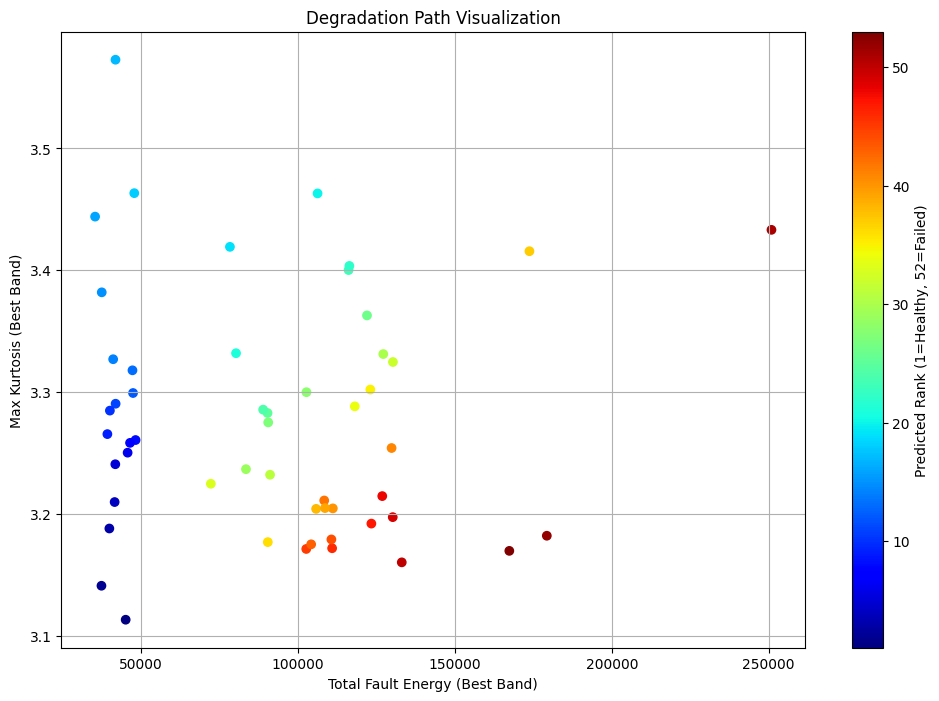

In [9]:
print("Interpreting Isomap timeline...")

# --- 1. Orient the Timeline ---
# We use our 'best_band_TFE' as the monotonic compass.
# As TFE goes up, degradation *must* go up.
tfe_corr = feature_df_v3['ISOMAP_Score'].corr(feature_df_v3['best_band_TFE'])

print(f"Correlation between Isomap Score and Best Band TFE: {tfe_corr:.2f}")

if tfe_corr > 0:
    # High ISOMAP_Score = High TFE (High degradation)
    # Rank in ascending order. Lowest score gets rank 1.
    print("Isomap score is POSITIVELY correlated with degradation.")
    sort_ascending = True

elif tfe_corr < 0:
    # High ISOMAP_Score = Low TFE (Low degradation)
    # The timeline is inverted. Rank in descending order.
    # Highest score (healthiest) gets rank 1.
    print("Isomap score is NEGATIVELY correlated with degradation.")
    sort_ascending = False

else:
    print("Warning: Zero correlation. Using default ascending sort.")
    sort_ascending = True

# --- 2. Create Final Rank Prediction ---
feature_df_v3['prediction'] = feature_df_v3['ISOMAP_Score'].rank(ascending=sort_ascending).astype(int)

# --- 3. Create Final Submission File ---
submission_df = feature_df_v3.reset_index()[['filename', 'prediction']]
submission_df = submission_df.sort_values('prediction')

submission_df.to_csv('isomap_v3_ranked_submission.csv', index=False)

print("\nFinal ranking created:")
print(submission_df.head())

print("\n---")
print(submission_df.tail())
print("\n---")
print("Submission file 'isomap_v3_ranked_submission.csv' saved!")

# --- 4. Plot the 2D Manifold ---
# This plot will help us VISUALIZE the degradation path.
# X-axis: Total Fault Energy (Monotonic)
# Y-axis: Kurtosis (Non-monotonic)
# Color: The rank (our timeline)

plt.figure(figsize=(12, 8))
plt.scatter(
    feature_df_v3['best_band_TFE'],
    feature_df_v3['best_kurtosis'],
    c=feature_df_v3['prediction'],  # Color by the final rank
    cmap='jet' # 1(blue)=healthy, 52(red)=failed
)
plt.xlabel('Total Fault Energy (Best Band)')
plt.ylabel('Max Kurtosis (Best Band)')
plt.title('Degradation Path Visualization')
plt.colorbar(label='Predicted Rank (1=Healthy, 52=Failed)')
plt.grid(True)
plt.savefig('degradation_path_v3.png')

print("Saved 'degradation_path_v3.png' to visualize the timeline.")